# Neural Network for MNIST database recognizing

This is a Neural Network developed without Machine Learning frameworks, using `numpy` and `matplotlib`, only for learning purposes. The objective of this project is practice Neural Networks Design principles and enhance knowledges on Machine Learning and Deep Learning.


## 1 - Library imports

In [568]:
import mnist
import numpy as np
import matplotlib.pyplot as plt
import os
from enum import Enum, unique
np.seterr(all='warn')

{'divide': 'warn', 'over': 'warn', 'under': 'warn', 'invalid': 'warn'}

## 2 - MNIST Datasets download

In [569]:
if(not os.path.isdir("./datasets/")):
    os.mkdir("./datasets")
if(not os.path.isfile("./datasets/train-images-idx3-ubyte.gz")):
    mnist.download_file("train-images-idx3-ubyte.gz", "./datasets")
if(not os.path.isfile("./datasets/train-labels-idx1-ubyte.gz")):
    mnist.download_file("train-labels-idx1-ubyte.gz", "./datasets")
if(not os.path.isfile("./datasets/t10k-images-idx3-ubyte.gz")):
    mnist.download_file("t10k-images-idx3-ubyte.gz", "./datasets")
if(not os.path.isfile("./datasets/t10k-labels-idx1-ubyte.gz")):
    mnist.download_file("t10k-labels-idx1-ubyte.gz", "./datasets")

## 3 - MNIST Datasets Load

In [570]:
train_images_raw = mnist.train_images()
train_labels_raw = mnist.train_labels()
test_images_raw = mnist.test_images()
test_labels_raw = mnist.test_labels()

train_images = np.transpose(train_images_raw.reshape(train_images_raw.shape[0], train_images_raw.shape[1]*train_images_raw.shape[2]))

train_labels = np.zeros((train_labels_raw.shape[0], train_labels_raw.max()+1))
train_labels[np.arange(train_labels_raw.shape[0]), train_labels_raw] = 1
train_labels = np.transpose(train_labels)

test_images = np.transpose(test_images_raw.reshape(test_images_raw.shape[0], test_images_raw.shape[1]*test_images_raw.shape[2]))

test_labels = np.zeros((test_labels_raw.shape[0], test_labels_raw.max()+1))
test_labels[np.arange(test_labels_raw.shape[0]), test_labels_raw] = 1
test_labels = np.transpose(test_labels)

print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

(784, 60000) (10, 60000) (784, 10000) (10, 10000)


## 4 - Activation functions enum

In [571]:
@unique
class Activation(Enum):
    SIGMOID = 1
    TANH = 2
    RELU = 3
    LEAKY_RELU = 4

## 5 - Hyperparameters

In [572]:
FEATURES = train_images.shape[0]
LAYERS = 3
LAYER_UNITS = np.array([16, 10, 10], dtype=np.uint32)
LAYER_ACTIVATIONS = np.array([Activation['RELU'], Activation['RELU'], Activation['RELU']])
ALPHA = 10e-5
LAMBDA_REG = 10e-4
ITERATIONS = 1000
EPSILON = 0.05

EXAMPLES = train_images.shape[1]

## 6 - Activation functions and it's derivatives

In [573]:
LEAKY_RELU_MULTIPLIER = 0.01

def linear_func(X_matrix, W_matrix, b_array):
    return np.dot(W_matrix, X_matrix) + b_array

def sigmoid(z):
    return 1/(1 + np.exp(-z))

def sigmoid_threshold(z):
    return np.round(z)

def tanh(z):
    return np.tanh(z)

def relu(z):
    return np.maximum(0, z)

def leaky_relu(z):
    return np.maximum(LEAKY_RELU_MULTIPLIER * z, z)

def derivative_sigmoid(z):
    return sigmoid(z) * (1 - sigmoid(z))

def derivative_tanh(z):
    return 1 - (tanh(z)**2)

def derivative_relu(z):
    if(z < 0):
        return 0
    else:
        return 1

def derivative_leaky_relu(z):
    if(z < 0):
        return LEAKY_RELU_MULTIPLIER
    else:
        return 1

derivative_relu = np.vectorize(derivative_relu)
derivative_leaky_relu = np.vectorize(derivative_leaky_relu)

## 7 - Normalization functions

In [574]:
def normalize_dataset(X_matrix):
    X_norm = np.zeros(X_matrix.shape)
    for i in range(X_matrix.shape[0]):
        #mu = np.mean(X_matrix[i])
        #sigma = np.std(X_matrix[i])
        X_norm[i] = X_matrix[i]/np.maximum(1, np.max(X_matrix[i]))
    return X_norm

def normalize_input(x_input, X_matrix):
    x_norm = np.zeros(x_input.shape)
    x_norm = x_input/np.maximum(1, np.max(X_matrix))
    return x_norm

## 8 - Forward and Backward Propagation Functions

In [575]:
def fwd_prop(A_previous, W_layer, b_layer, activationType = Activation['SIGMOID']):
    Z_layer = linear_func(A_previous, W_layer, b_layer)
    if (activationType == Activation['SIGMOID']):
        A_layer = sigmoid(Z_layer)
    elif (activationType == Activation['TANH']):
        A_layer = tanh(Z_layer)
    elif (activationType == Activation['RELU']):
        A_layer = relu(Z_layer)
    elif (activationType == Activation['LEAKY_RELU']):
        A_layer = leaky_relu(Z_layer)
    else:
        A_layer = sigmoid(Z_layer)
    return A_layer, Z_layer

def back_prop(dA_layer, A_previous, Z_layer, W_layer, b_layer, activationType = Activation['SIGMOID']):
    if (activationType == Activation['SIGMOID']):
        dZ_layer = np.multiply(dA_layer, derivative_sigmoid(Z_layer))
    elif (activationType == Activation['TANH']):
        dZ_layer = np.multiply(dA_layer, derivative_tanh(Z_layer))
    elif (activationType == Activation['RELU']):
        dZ_layer = np.multiply(dA_layer, derivative_relu(Z_layer))
    elif (activationType == Activation['LEAKY_RELU']):
        dZ_layer = np.multiply(dA_layer, derivative_leaky_relu(Z_layer))
    else:
        dZ_layer = np.multiply(dA_layer, derivative_sigmoid(Z_layer))
    
    dW_layer = np.dot(dZ_layer, np.transpose(A_previous))/dZ_layer.shape[1]
    db_layer = np.sum(dZ_layer, axis = 1, keepdims = True)/dZ_layer.shape[1]
    dA_previous = np.dot(np.transpose(W_layer), dZ_layer)

    return dA_previous, dW_layer, db_layer   

## 9 - Predict Function

In [576]:
def predict(X, W, b,
            layers = LAYERS,
            layer_activations = LAYER_ACTIVATIONS):
    A = X
    for i in range(1, layers+1):
        A, z = fwd_prop(A, W[i], b[i], layer_activations[i-1])
    return A

## 10 - Cost function

In [577]:
def cost(X, y, W, b, lambda_reg = LAMBDA_REG):
    y_prediction = predict(X, W, b)
    regularization = 0
    '''
    try:
        loss = - ((np.dot(y, np.transpose(np.log(y_prediction)))) + np.dot((1 - y), np.transpose(np.log(1 - y_prediction))))
    except FloatingPointError:
        y_prediction = abs(y_prediction-0.00000001)
        loss = - ((np.dot(y, np.transpose(np.log(y_prediction)))) + np.dot((1 - y), np.transpose(np.log(1 - y_prediction))))
    '''
    loss = (1/2)*((y_prediction - y)**2)
    #print(y_prediction.shape, y.shape, loss.shape)
    for i in W:
        regularization += np.sum(i**2)
    cost = (np.sum(loss, axis = 1, keepdims=True)/y.shape[1]) + ((lambda_reg/(2*y.shape[1]))*regularization)
    return cost

## 11 - Fit Function

In [578]:
def fit(X, y,
        W_previous = None,
        b_previous = None,
        features = FEATURES,
        layers = LAYERS,
        layer_units = LAYER_UNITS,
        layer_activations = LAYER_ACTIVATIONS,
        examples = EXAMPLES,
        alpha = ALPHA,
        lambda_reg = LAMBDA_REG,
        iterations = ITERATIONS,
        epsilon = EPSILON):
    
    W = {1: np.random.rand(layer_units[0], features)}
    dW = {1: np.zeros([layer_units[0], features])}
    b = {1:np.random.rand(layer_units[0], 1)}
    db = {1: np.zeros([layer_units[0], 1])}
    Z = {0: X}
    A = {0: X}
    dA = {0: np.array([])}
    for k in range(layers - 1):
        W[k+2] = np.random.rand(layer_units[k+1], layer_units[k])
        dW[k+2] = np.zeros([layer_units[k+1], layer_units[k]])
        b[k+2] = np.random.rand(layer_units[k+1], 1)
        db[k+2] = np.zeros([layer_units[k+1], 1])
        Z[k+1] = np.zeros([layer_units[k+1], examples])
        A[k+1] = np.zeros([layer_units[k+1], examples])
        dA[k+1] = np.zeros([layer_units[k+1], examples])

    if(W_previous != None and b_previous != None):
        W = W_previous
        b = b_previous

    cost_points = []

    for i in range(iterations):

        for j in range(layers):
            A[j+1], Z[j+1] = fwd_prop(A[j], W[j+1], b[j+1], layer_activations[j])

        #if(layer_activations[len(layer_activations) - 1] == Activation["RELU"]):
            #A[layers] = derivative_relu(A[layers])
        dA[layers] = A[layers] - y

        for j in range(layers-1, -1, -1):
            dA[j], dW[j+1], db[j+1] = back_prop(dA[j+1], A[j], Z[j+1], W[j+1], b[j+1], layer_activations[j])
        
        for j in range(1, layers+1):
            W[j] = (W[j] * (1 - ((alpha*lambda_reg)/y.shape[1]))) - (alpha*dW[j])
            b[j] = b[j] - (alpha*db[j])
  
        cost_points.append(cost(X, y, W, b))

        #print(np.transpose(cost(X, y, W, b)))
        #print(np.sum(dA[layers], axis = 1))
        #print(Z[layers][:, 0])
        
        print(y[:, 0])
        print()
        #print()
        #print(W, b)

    return W, b

## 12 - Training the N.N.

In [579]:
test_images_normalized = normalize_dataset(test_images)
W_final, b_final = fit(test_images_normalized, test_labels)

[[-5.95290468]
 [-3.41233631]
 [-4.29219672]
 [-5.31430444]
 [-5.20654045]
 [-5.43307799]
 [-6.37137823]
 [-4.88459955]
 [-5.82314325]
 [-5.3812006 ]
 [-5.02909309]
 [-7.37281942]
 [-3.6590275 ]
 [-4.55511045]
 [-5.31291254]
 [-5.12707926]]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]

[[-12.0251947 ]
 [ -7.24433378]
 [ -8.44303272]
 [-10.26560756]
 [-10.30876069]
 [-10.47130186]
 [-12.56598056]
 [ -9.72509452]
 [-11.23216009]
 [-10.6231329 ]
 [-10.00830218]
 [-14.13607022]
 [ -7.54035405]
 [ -9.2607034 ]
 [-10.42450702]
 [ -9.95644627]]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]

[[-17.40550355]
 [-10.63976413]
 [-12.1209738 ]
 [-14.65268395]
 [-14.82964273]
 [-14.93548846]
 [-18.05363748]
 [-14.01405551]
 [-16.02483389]
 [-15.26762107]
 [-14.42029359]
 [-20.12831712]
 [-10.97936796]
 [-13.43029987]
 [-14.95357083]
 [-14.23561906]]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]

[[-22.1730084 ]
 [-13.648996  ]
 [-15.38057724]
 [-18.54062709]
 [-18.83619226]
 [-18.89160984]
 [-22.9101175 ]
 [-17.81503328]
 [-20.27208245]
 [

KeyboardInterrupt: 

## 13 - Testing the N.N.

In [ ]:
W_save = W_final
b_save = b_final

8

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


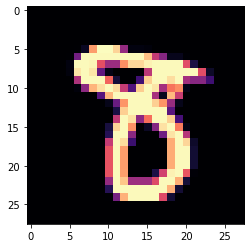

In [ ]:
index = int(np.round(np.random.rand()*len(test_images_raw)))

plt.imshow(test_images_raw[index], cmap='magma')
print(test_labels_raw[index])
print()
test_sample = normalize_input(test_images[:, index].reshape(test_images[:, index].shape[0], 1), test_images)
print(np.transpose(predict(test_sample, W_save, b_save)))
print()
print(test_labels[:, index])
plt.show()